In [ ]:
%pip install transformers seaborn pandas matplotlib
%pip install https://github.com/sadrasabouri/plda/tarball/master

In [22]:
# Imports of necessary packages
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.nn.functional import normalize
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import numpy as np
import json
import torch
import plda
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


PLDA_classifier = plda.Classifier()

In [5]:
def get_raw_data():
    train_data_url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json"
    test_data_url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/dev.json"
    train_data_json = requests.get(train_data_url).json()
    test_data_json = requests.get(test_data_url).json()
    return train_data_json, test_data_json

CLASSES = ['PREAMBLE', 'NONE', 'FAC', 'ARG_RESPONDENT', 'RLC', 'ARG_PETITIONER', 'ANALYSIS', 'PRE_RELIED', 'RATIO', 'RPC', 'ISSUE', 'STA', 'PRE_NOT_RELIED']
train_data_json, test_data_json = get_raw_data()

In [ ]:
query_tokenizer = AutoTokenizer.from_pretrained('facebook/spar-wiki-bm25-lexmodel-query-encoder')
query_encoder = AutoModel.from_pretrained('facebook/spar-wiki-bm25-lexmodel-query-encoder')

In [12]:
def get_word_embedding(query):
    input_ids = query_tokenizer(query, truncation=True, return_tensors='pt')
    query_emb = query_encoder(**input_ids).last_hidden_state[:, 0, :]
    return query_emb

def get_predictions(query, labels_dev):
    tensor_value = get_word_embedding(query)
    numpy_value = np.squeeze(tensor_value.detach().numpy())
    predictions, log_p_predictions = PLDA_classifier.predict(numpy_value)
    predictions = labels_dev[predictions]
    return predictions

In [8]:
labels_all=[]
data=[]

for item in train_data_json:
  for annotation in item['annotations']:
    for results in annotation['result']:
      data.append(results['value']['text'].strip())
      labels_all.append(results['value']['labels'][0])

TRAIN_SIZE = len(labels_all)

In [9]:
X = []
y = []
labels = list(set(labels_all))
progress = 0
for sentence, label in zip(data[:TRAIN_SIZE], labels_all[:TRAIN_SIZE]):
    tensor_value = get_word_embedding(sentence)
    numpy_value = np.squeeze(tensor_value.detach().numpy())
    X.append(numpy_value)
    y.append(labels.index(label))
    progress += 1
    if progress % 500 == 0:
        print('Progress Percent = {}%'.format(100 * progress / TRAIN_SIZE))

X = np.array(X)
y = np.array(y)

Progress Percent = 1.7249706754985166%
Progress Percent = 3.449941350997033%
Progress Percent = 5.17491202649555%
Progress Percent = 6.899882701994066%
Progress Percent = 8.624853377492583%
Progress Percent = 10.3498240529911%
Progress Percent = 12.074794728489616%
Progress Percent = 13.799765403988133%
Progress Percent = 15.52473607948665%
Progress Percent = 17.249706754985166%
Progress Percent = 18.97467743048368%
Progress Percent = 20.6996481059822%
Progress Percent = 22.424618781480714%
Progress Percent = 24.149589456979232%
Progress Percent = 25.874560132477747%
Progress Percent = 27.599530807976265%
Progress Percent = 29.32450148347478%
Progress Percent = 31.0494721589733%
Progress Percent = 32.77444283447181%
Progress Percent = 34.49941350997033%
Progress Percent = 36.22438418546885%
Progress Percent = 37.94935486096736%
Progress Percent = 39.67432553646588%
Progress Percent = 41.3992962119644%
Progress Percent = 43.124266887462916%
Progress Percent = 44.84923756296143%
Progress

In [10]:
PLDA_classifier.fit_model(np.array(X), np.array(y))

In [13]:
labels_all_test=[]
data_test=[]

for i in test_data_json:
  for annotations in i['annotations']:
    for results in annotations['result']:
      data_test.append(results['value']['text'].strip())
      labels_all_test.append(results['value']['labels'][0])

preds_test=[]
labels_test = list(set(labels_all))
for query in data_test:
  preds = get_predictions(query, labels_test)
  preds_test.append(preds)

In [14]:
def get_metrics():
  f1score = f1_score(labels_all_test, preds_test, average="macro")
  matches=0
  for i,j in zip(labels_all_test, preds_test):
    if i==j:
      matches+=1
  precision=matches/len(labels_all_test)
  return f1score, precision

f1score, precision = get_metrics()
print("F1 Score:", f1score)
print("Precision:", precision)

F1 Score: 0.3391460831027944
Precision: 0.38823529411764707


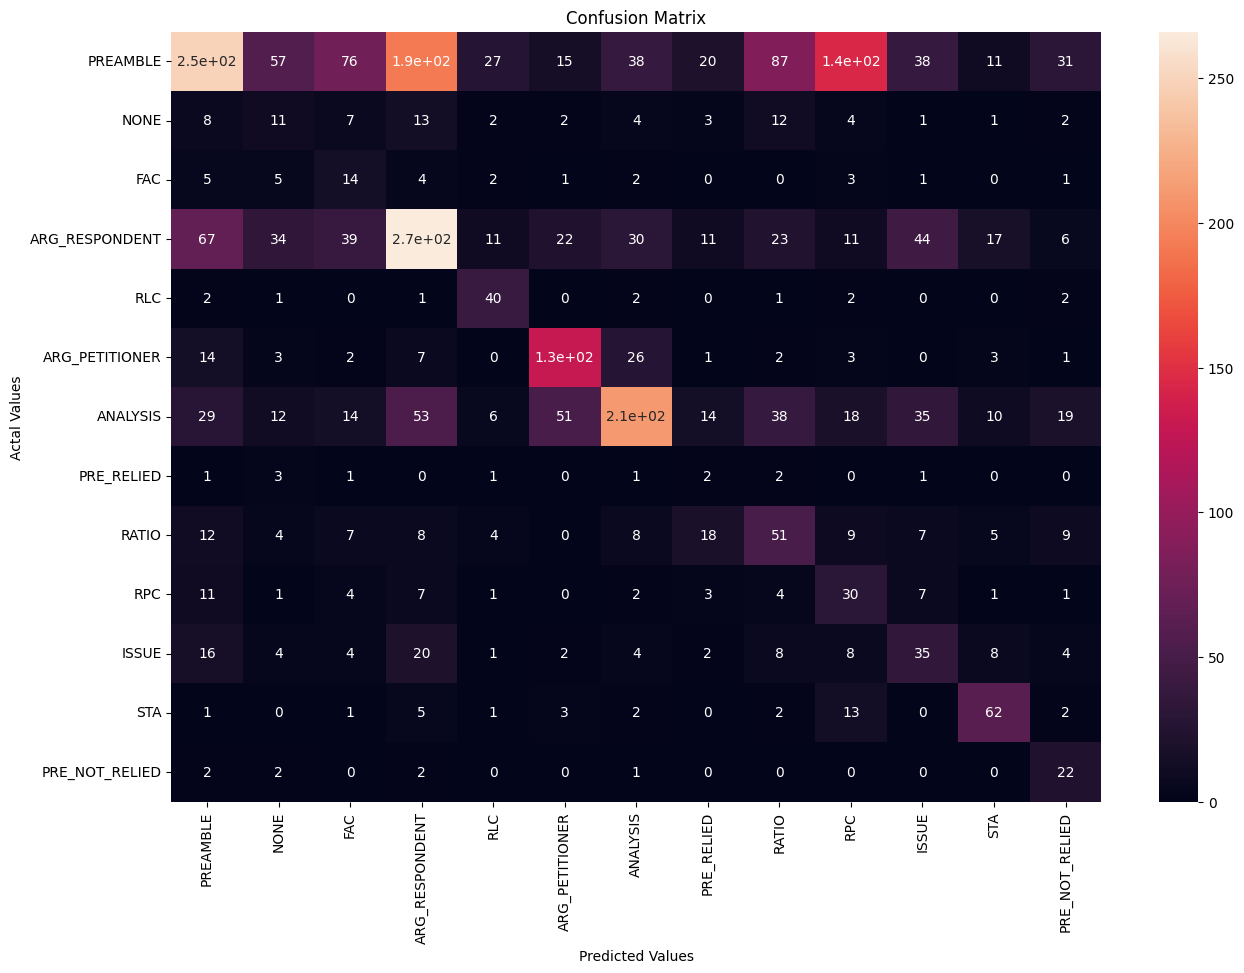

In [23]:
cm = confusion_matrix(labels_all_test, preds_test)
cm_df = pd.DataFrame(cm, index = CLASSES,columns = CLASSES)

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig("matrix_LR.png")